In [13]:
import yfinance as yf
import numpy as np
from autograd import grad
import autograd.numpy as np_
import matplotlib.pyplot as plt


# Funções Auxiliares

In [29]:
def accuracy(y_test, y_est):
    return np.mean((y_est-y_test)**2)

In [30]:
def erro(parametros):
    w,x,y=parametros
    y_est = x@w.T
    mse = (y-y_est)**2
    return(np_.mean(mse))

In [31]:
def plot_erro(parametros):
    w,x,y=parametros
    y_est = x@w.T
    mse = (y-y_est)**2
    return(np_.mean(mse))

In [32]:
def normalizar(dados):
    # Normaliza os dados para a faixa [0, 1]
    return (dados - np.min(dados)) / (np.max(dados) - np.min(dados))

In [33]:
def preparar_dados(data, window=5):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        Y.append(data[i + window])
    return np.array(X), np.array(Y)

# Etapa 2

In [34]:

def execute(ticker, periodo):
    acao = yf.Ticker(ticker)
    hist = acao.history(period=periodo)
    
    hist_train = hist[:int(len(hist) * 0.7)]
    hist_test = hist[int(len(hist) * 0.7):]
    alpha = 0.01
    
    hist_train = hist_train[['Close']].dropna()
    hist_test = hist_test[['Close']].dropna()
    

    X_train, Y_train = preparar_dados(hist_train['Close'].values)
    X_test, Y_test = preparar_dados(hist_test['Close'].values)
    
    X_train = normalizar(X_train)
    Y_train = normalizar(Y_train)
    X_test = normalizar(X_test)
    Y_test = normalizar(Y_test)
    w = np.random.rand(X_train.shape[1])
    print(X_train.shape,Y_train.shape,w.shape)
    list_erros=[]
    for n in range(1000):  
        g = grad(erro)
        grad_ = g((w, X_train, Y_train))
        erro_plot= plot_erro((w, X_train, Y_train))
        list_erros.append(erro_plot)
        w -= alpha * grad_[0]
    
    y_est =X_test@ w
    acuracia = accuracy(Y_test, y_est)
    return  list_erros

erros=(execute("MSFT", "10y"))




(1756, 5) (1756,) (5,)


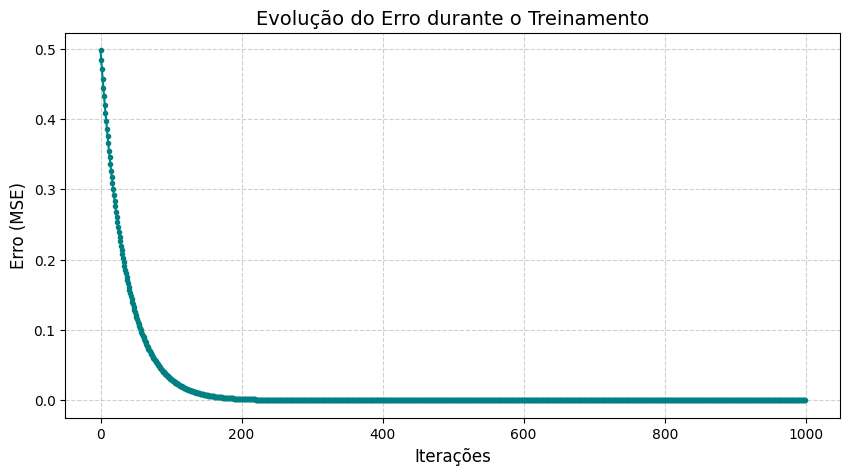

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(erros, color='teal', linewidth=1.5, marker='o', markersize=3, linestyle='-')
plt.title("Evolução do Erro durante o Treinamento", fontsize=14)
plt.xlabel("Iterações", fontsize=12)
plt.ylabel("Erro (MSE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Etapas 3 e 4

In [36]:
def execute(ticker, periodos=['1y', '5y', '10y']):
    alpha = 0.01
    lag = 5
    erro_data = []
    predicao_data = []
    
    for periodo in periodos:
        acao = yf.Ticker(ticker)
        hist = acao.history(period=periodo)
        
        for freq in ['D', 'W', 'M']:
            hist_resampled = hist['Close'].resample(freq).mean().dropna()
            
            hist_train = hist_resampled[:int(len(hist_resampled) * 0.7)]
            hist_test = hist_resampled[int(len(hist_resampled) * 0.7):]

            if hist_train.empty or hist_test.empty:
                continue
            

            X_train, Y_train = preparar_dados(hist_train.values, lag)
            X_test, Y_test = preparar_dados(hist_test.values, lag)
            
            if X_train.size == 0 or Y_train.size == 0 or X_test.size == 0 or Y_test.size == 0:
                continue
                        
            X_train = normalizar(X_train)
            Y_train = normalizar(Y_train)
            X_test = normalizar(X_test)
            Y_test = normalizar(Y_test)
            
            w = np.random.rand(X_train.shape[1])
            erros = []
            for n in range(1000):
                g = grad(erro)
                grad_ = g((w, X_train, Y_train))
                erro_plot = plot_erro((w, X_train, Y_train))
                erros.append(erro_plot)
                w -= alpha * grad_[0]
            
            y_est = X_test @ w
            acuracia = accuracy(Y_test, y_est)
            
            erro_data.append((erros, periodo, freq))
            predicao_data.append((Y_test, y_est, periodo, freq))
    
    return erro_data, predicao_data

erro_data, predicao_data = execute("MSFT", periodos=["1y", "5y", "10y"])


/tmp/ipykernel_5832/2849637140.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_resampled = hist['Close'].resample(freq).mean().dropna()
/tmp/ipykernel_5832/2849637140.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_resampled = hist['Close'].resample(freq).mean().dropna()
/tmp/ipykernel_5832/2849637140.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_resampled = hist['Close'].resample(freq).mean().dropna()


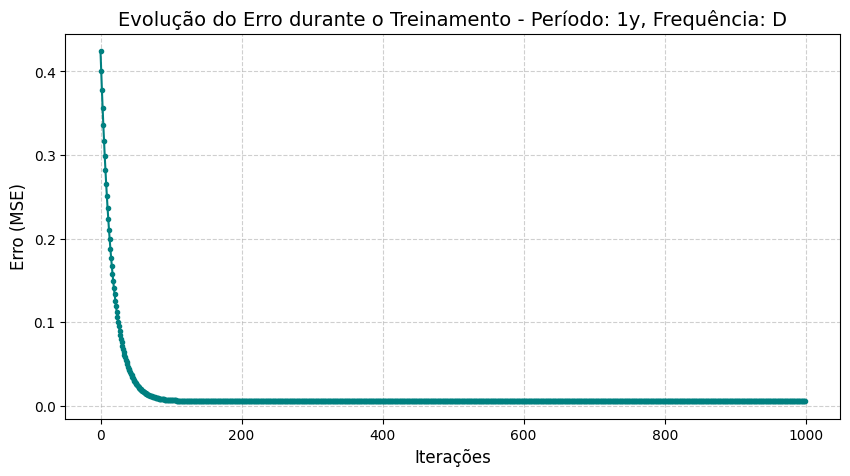

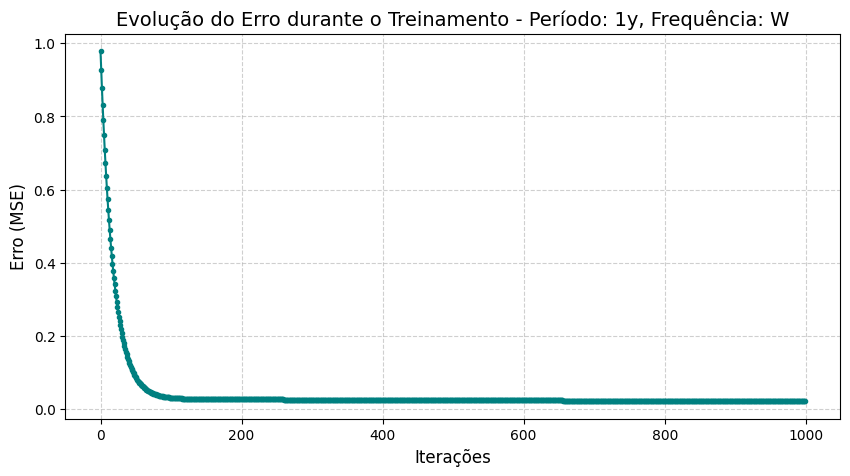

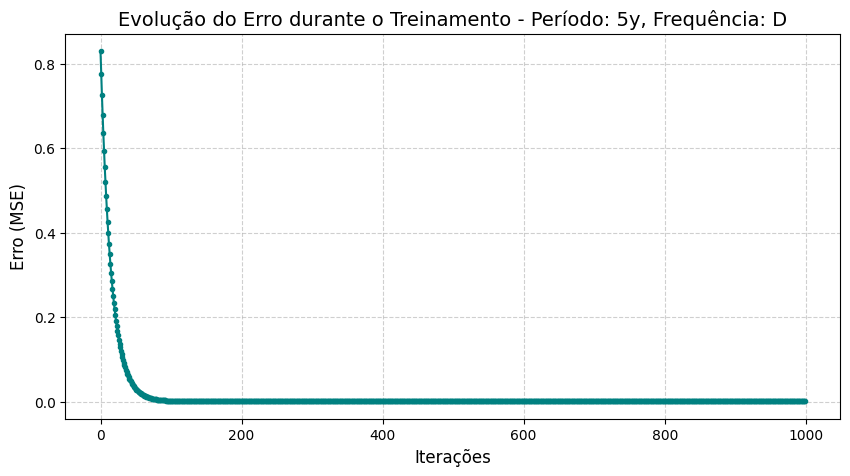

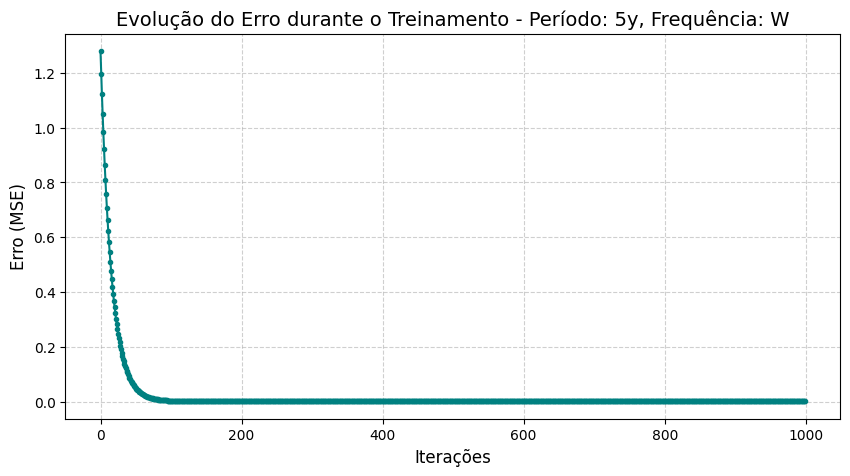

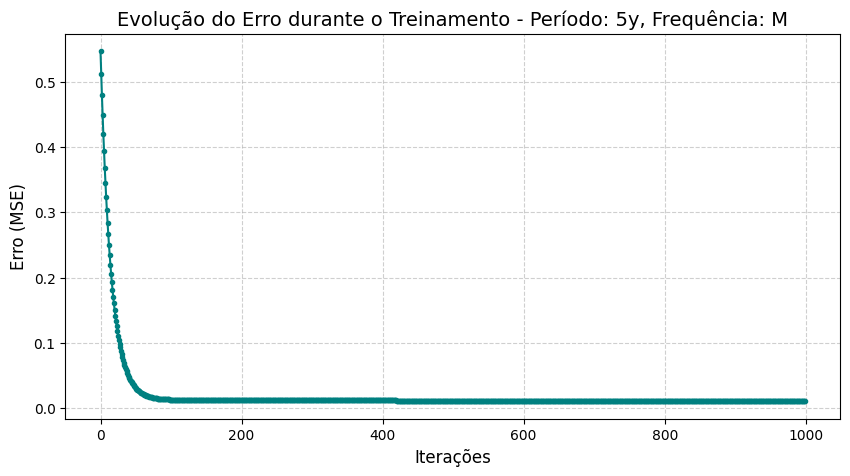

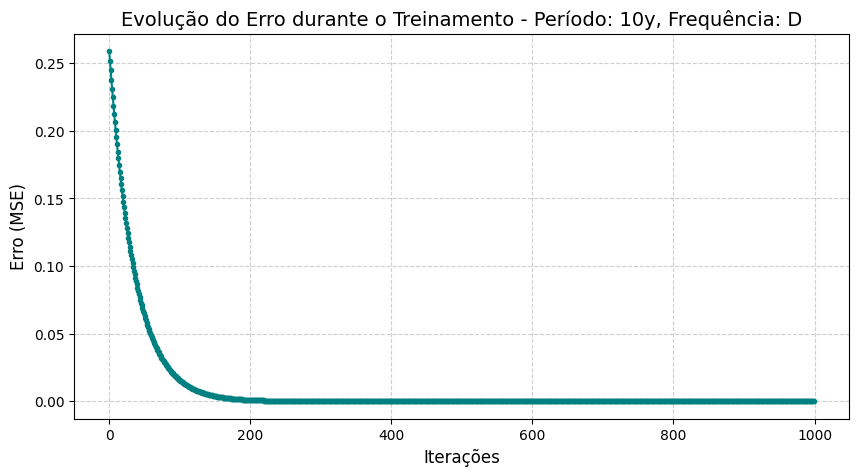

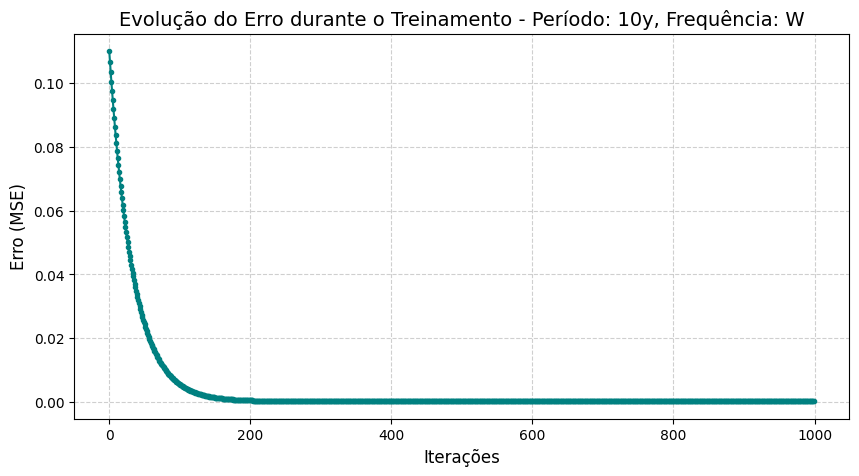

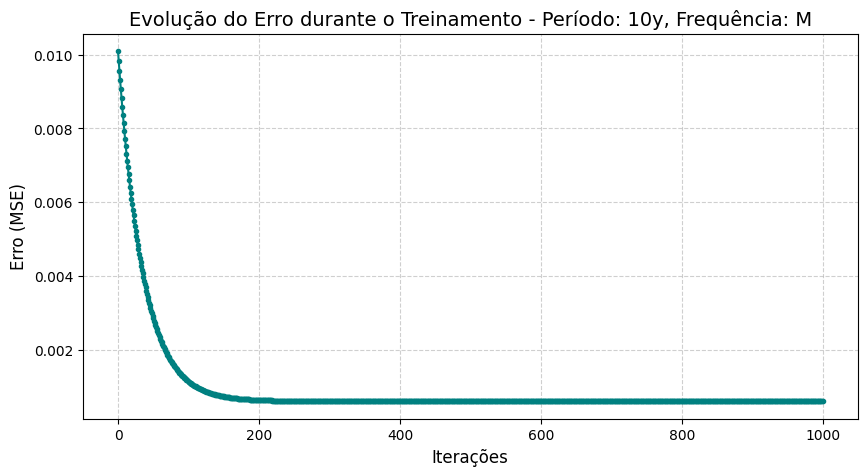

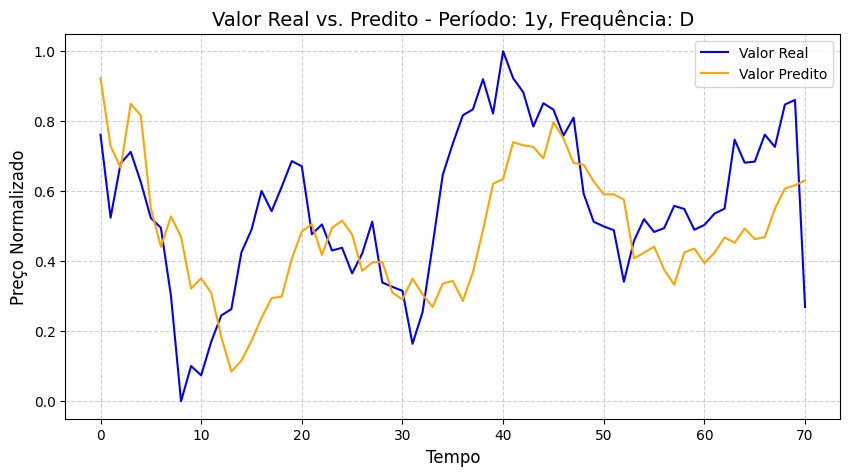

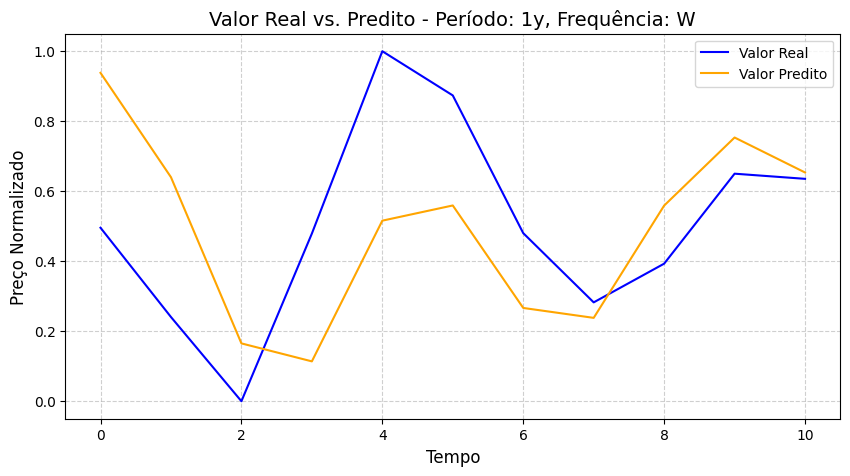

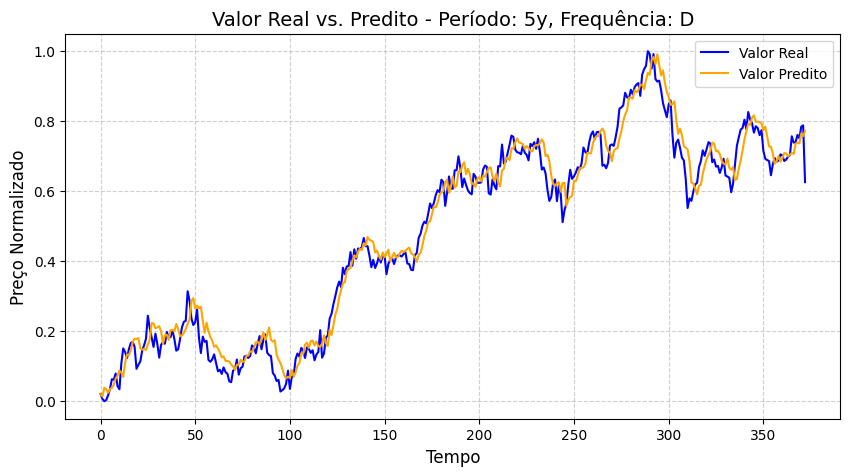

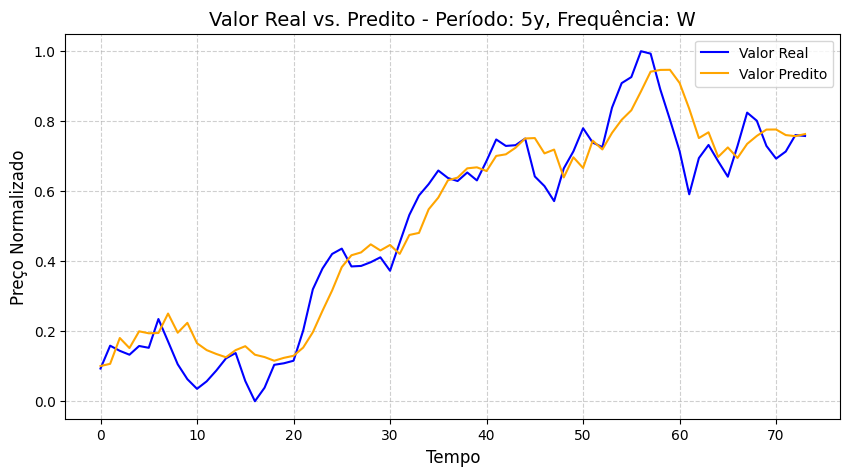

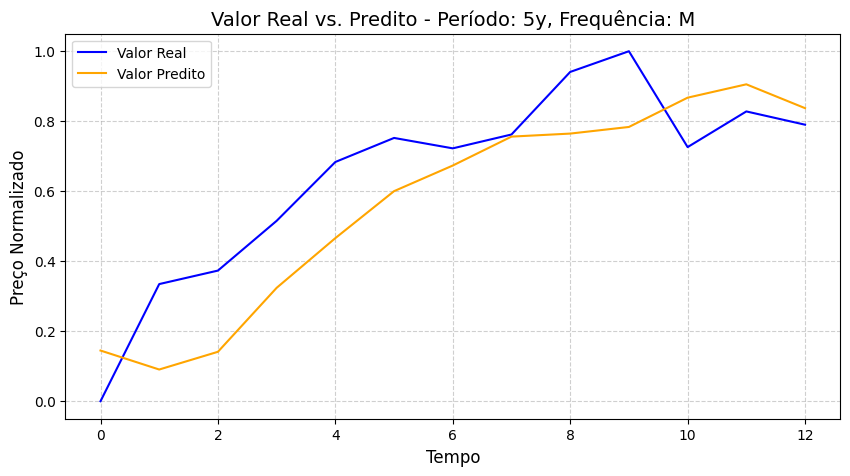

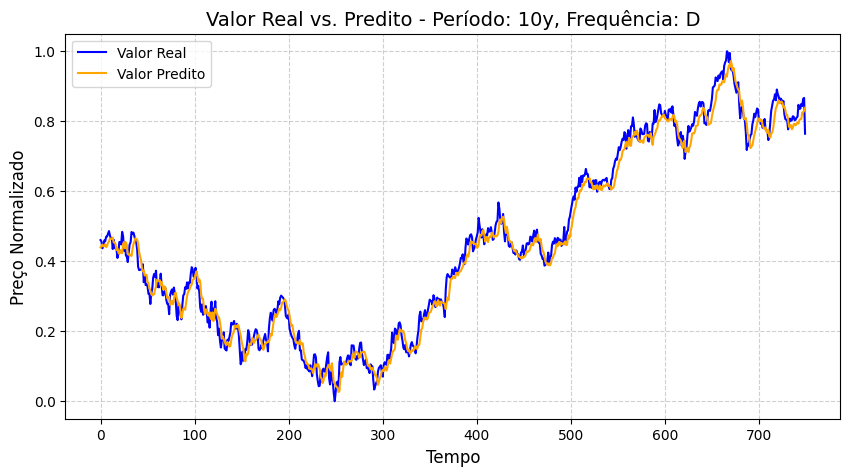

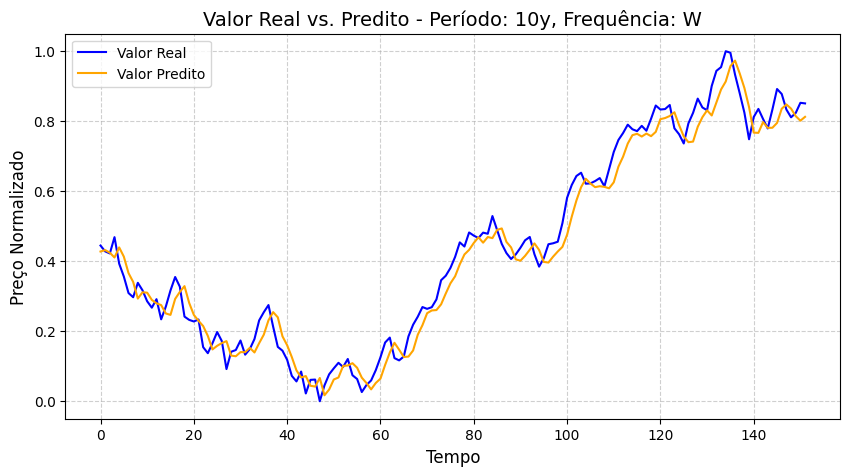

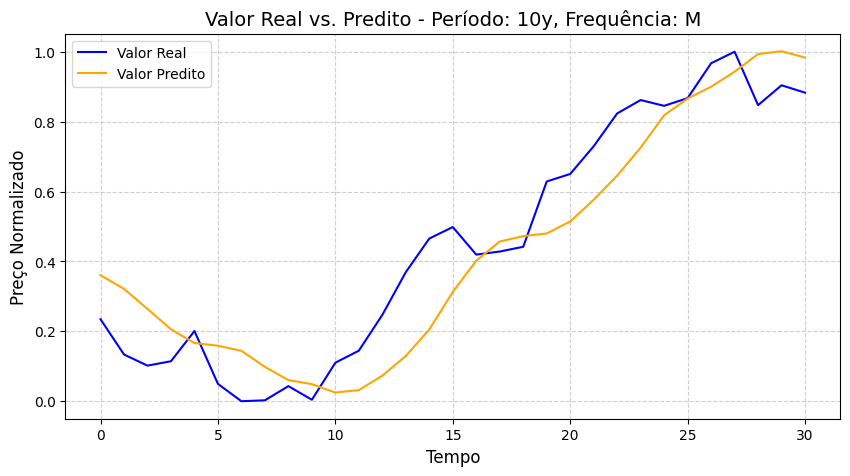

In [37]:
# Gráfico de Erros
for erros, periodo, freq in erro_data:
    plt.figure(figsize=(10, 5))
    plt.plot(erros, color='teal', linewidth=1.5, marker='o', markersize=3, linestyle='-')
    plt.title(f"Evolução do Erro durante o Treinamento - Período: {periodo}, Frequência: {freq}", fontsize=14)
    plt.xlabel("Iterações", fontsize=12)
    plt.ylabel("Erro (MSE)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Gráfico de Predição vs. Real
for Y_test, y_est, periodo, freq in predicao_data:
    plt.figure(figsize=(10, 5))
    plt.plot(Y_test, label="Valor Real", color='blue')
    plt.plot(y_est, label="Valor Predito", color='orange')
    plt.title(f"Valor Real vs. Predito - Período: {periodo}, Frequência: {freq}", fontsize=14)
    plt.xlabel("Tempo", fontsize=12)
    plt.ylabel("Preço Normalizado", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
